In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
# This query sorts all of the rouses in the database Measurement table by date (descending) and then finds the
# first value (the most recent value )
most_recent_measurement = session.query(Measurement.date).order_by(desc(Measurement.date)).first()[0]
# This splits the date string into a list of values representing the year, month, and date (so that these values
# can be processed using the datetime package below)
most_recent_measurement = [int(val) for val in most_recent_measurement.split('-')]
print(most_recent_measurement)

[2017, 8, 23]


C:\Users\niels\AppData\Local\Temp\ipykernel_23652\3569317526.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels([


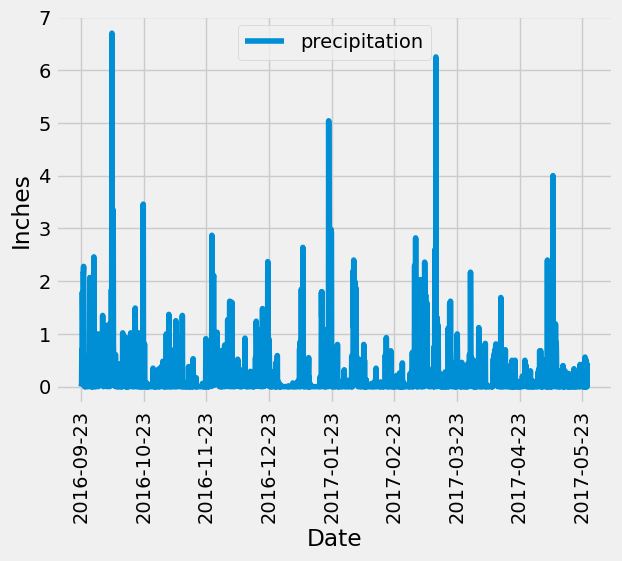

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Getting a datetime time object using the value found above 
latest_date = dt.date(*most_recent_measurement)

# Calculate the date one year from the last date in data set.
one_year_ago_date = latest_date - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
year_perc_data = session.\
    query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago_date).\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Date and precipitation values are pulled from each tuple in the output list from
# the query using a list comprehension.
precip_dataframe = pd.DataFrame({
    "date" : [tup[0] for tup in year_perc_data],
    "precipitation" : [tup[1] for tup in year_perc_data]
})

original_df = percip_dataframe.copy()

# Sort the dataframe by date
# Null values are dropped
precip_dataframe.dropna(inplace=True)
# The values are sorted in place by date
precip_dataframe.sort_values(by=["date"], inplace=True)
# The index is reset to make more sense after the sort.
precip_dataframe.reset_index(inplace=True, drop=True)


# Use Pandas Plotting with Matplotlib to plot the data
plot = precip_dataframe.plot(
    kind="line"
)

# Setting the x tick labels to a more manageable number of dates.
plot.set_xticklabels([
    "2016-08-23",
    "2016-09-23",
    "2016-10-23",
    "2016-11-23",
    "2016-12-23",
    "2017-01-23",
    "2017-02-23",
    "2017-03-23",
    "2017-04-23",
    "2017-05-23",
    "2017-06-23",
    "2017-07-23",
    "2017-08-23",
], rotation=90)

# Setting the x and y labels for the graph
plot.set_ylabel("Inches")
plot.set_xlabel("Date")

# Displaying the graph
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_dataframe.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset
# Counting the number of stations contained in a list of stations in the Station table
station_query = session.\
    query(Station.station).\
    count()

station_query

9

In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# Querying all of the stations in the Measurement table, along with the number of rows associated with each
# of those stations. We do this by grouping by the station identifier, then counting the number of stations,
# then ordering the resulting list by the number of rows associated with each station.
stations_by_rows = session.\
    query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.date))).\
    all()

stations_by_rows

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [51]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Getting the identifier for the most active station by finding the first value stored in the first row of the above
# defined table (i.e. by taking the row representing the most active station, then getting the value stored in index
# 0 (the identifier))
most_active_station_id = stations_by_rows[0][0]

# Columns for the DataFrame defined below
mes_columns = ["date", "prcp", "tobs"]

# This is a query that stores all of the entries in the Measurement table associated with the given station
# This query finds the min, max and average values for the most active station using the built in sqlalchemy
# functions (func.min(), func.max(), and func.avg())
active_station_values = session.\
    query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter_by(station = "USC00519281").\
    all()

print(active_station_values)

[(54.0, 85.0, 71.66378066378067)]


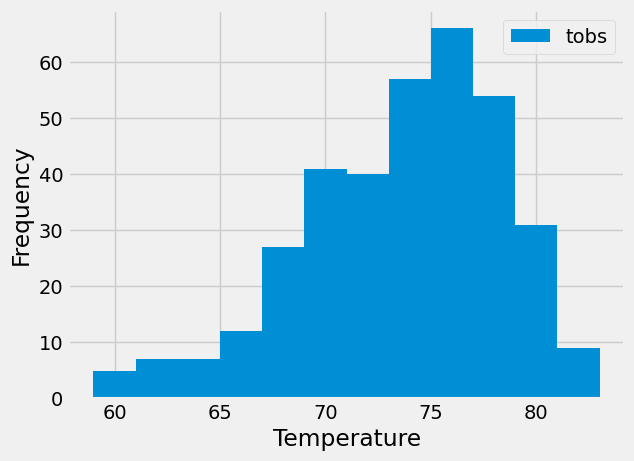

In [77]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Getting the the date one year from the most recent measurement at  the most active station. I did this by splitting
# The date from the query defined below, then dropping that value into datetime to get the most recent measurement from
# the given station. This value is then subtracted from a dt.timedelta() value to get the date exactly one year from the
# most recent measurement from the given station
most_recent_date = session.\
    query(Measurement.station, Measurement.date).\
    filter(Measurement.station == "USC00519281").\
    order_by(desc(Measurement.date)).\
    first()

# Getting the date that is exactly one year before the most recent measurement taken at the most active station
ma_most_recent_date = [int(val) for val in most_recent_date[1].split('-')]
ma_one_year_ago = dt.datetime(*ma_most_recent_date) - dt.timedelta(days = 365)

# Querying for the data associated withe the past year of data from the most active station
ma_last_year_data = session.\
    query(Measurement.date, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.station == "USC00519281", Measurement.date >= ma_one_year_ago).\
    all()

# This is a data frame generated from the data pulled from the above query. I used a DataFrame to make graphing
# easier. Note that index 0 in vals below represents the date the measurement was taken, while index 2 in vals 
# below represents the temperature recorded at that date.
ma_last_year_df = pd.DataFrame({
    "date" : [vals[0] for vals in ma_last_year_data],
    "tobs" : [vals[2] for vals in ma_last_year_data],
})

# A figure to display the graph in
fig, ax = plt.subplots(1, 1)

# A histogram to display the data
plot = ma_last_year_df.hist(
    column="tobs",
    bins=12,
    label="tobs",
    ax = ax
)

# Adding styling to the graph
ax.legend()
ax.set_title("")
ax.set_ylabel("Frequency")
ax.set_xlabel("Temperature")

plt.show()


# Close Session

In [74]:
# Close Session
session.close()